In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import seaborn as sns
import dask.array as da
import dask.dataframe as ddf
import joypy
import cartopy.crs as ccrs

In [31]:
#open dataset
dm_tprime_xr_reanalysis = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')
# tprime_xr = xr.open_dataset('/project2/geos39650/jet_stream/data/t_prime_no_resample_cimp6_2015-12-01_2025-03-01.nc4')
dm_tprime_xr_cmip = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t_prime_cimp6_1980_2020.nc4')

## Hovmoller

In [63]:
def hovmoller(data,lat_range,dates):
    data_strip = data.sel({'latitude': lat_range, 'time':dates})
    meaned_data_strip = data_strip.mean(dim=['latitude']).reset_coords('dayofyear',drop=True)
    #re-assign longitudes to make them more intuitive for people
    meaned_data_strip = meaned_data_strip.\
    assign_coords(longitude=(((meaned_data_strip.longitude + 180) % 360) - 180)).sortby('longitude')
    
    if 40.25 in data.latitude: #if its reanalysis instead of climate model output
        titlestr = r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter %i for Reanalysis"%selected_dates[0].year
    else:
        titlestr = r"$T'$ at Latitude $\sim 40 ^\circ$ in Winter %i for CMIP6"%selected_dates[0].year
    meaned_data_strip.to_array().plot(vmax=25)
    plt.title(titlestr)
    plt.show()

#### A bunch of exploratory plots

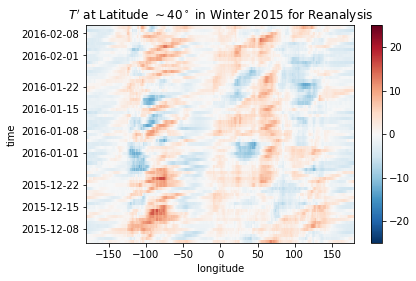

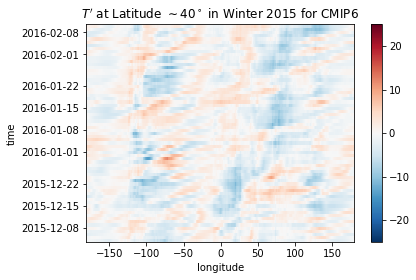

In [64]:
#some grooming
    #select only 10 weeks in the winter of 2016
weeks = 10
period = weeks*7-1
selected_dates= pd.date_range('2015-12-04',periods=period,freq='D')


#choose a latitude range where a lot of people live, like near chi-town
lat_range_reanalysis = np.arange(40,45.25,0.25)
lat_range_cmip = slice(40,45.25)

#and plot!

#compare reanalysis and climate output for the same date
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

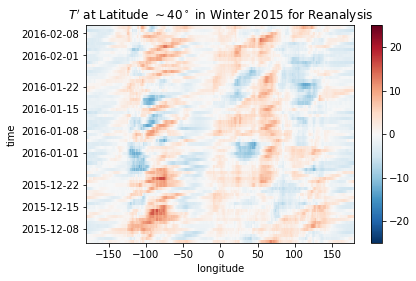

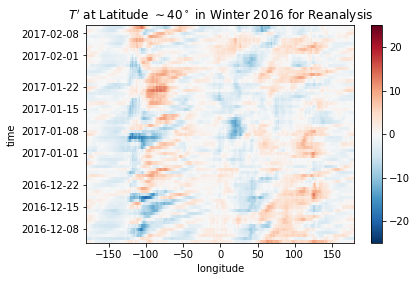

In [65]:
#two adjacent winters in reanalysis
selected_dates= pd.date_range('2015-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('2016-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)

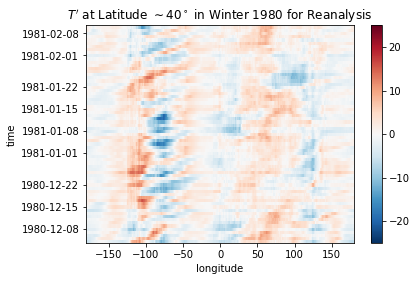

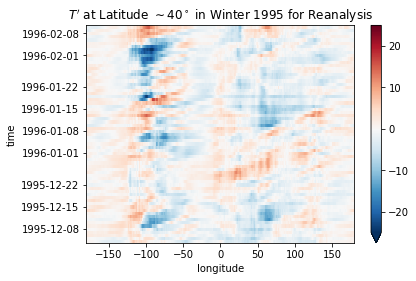

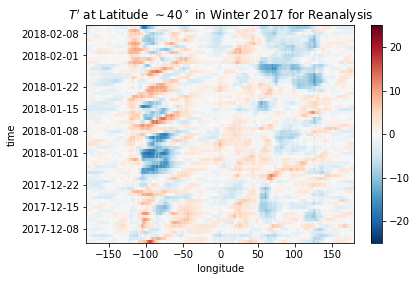

In [66]:
# now lets look at the difference between three winters in the past
selected_dates= pd.date_range('1980-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('1995-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)
selected_dates= pd.date_range('2017-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_reanalysis,lat_range_reanalysis,selected_dates)

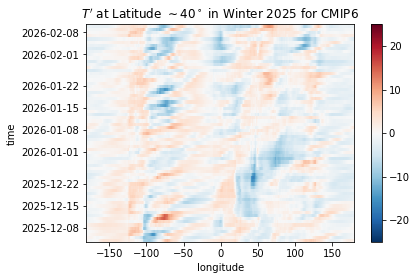

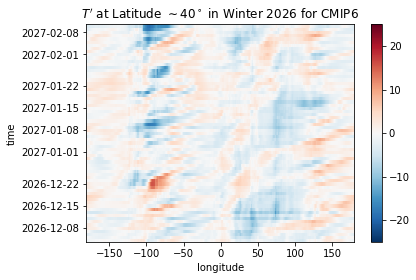

In [67]:
#two adjacent winters in climate model output
selected_dates= pd.date_range('2025-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2026-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

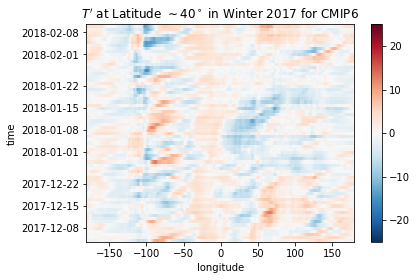

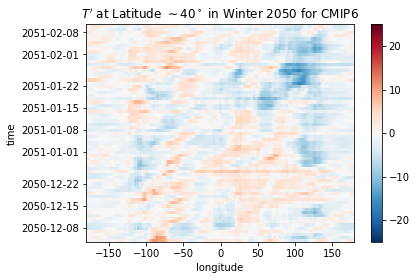

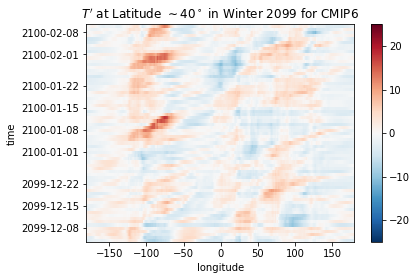

In [68]:
# difference between three winters in the future
selected_dates= pd.date_range('2017-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2050-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)
selected_dates= pd.date_range('2099-12-04',periods=period,freq='D')
hovmoller(dm_tprime_xr_cmip,lat_range_cmip,selected_dates)

seems like differences between decades look like the differences between 2 adjacent winters, at least by eye, for both reanalysis and climate model output

## Joy division

In [13]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr

def joy_div(data,data_key='t_prime',decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data.index)
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key,data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_df_chi, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(10,10))
    plt.xlabel("T' [K]")
    plt.xlim(-20,20)
    plt.ylabel("year")
    plt.show()
    return data_filter

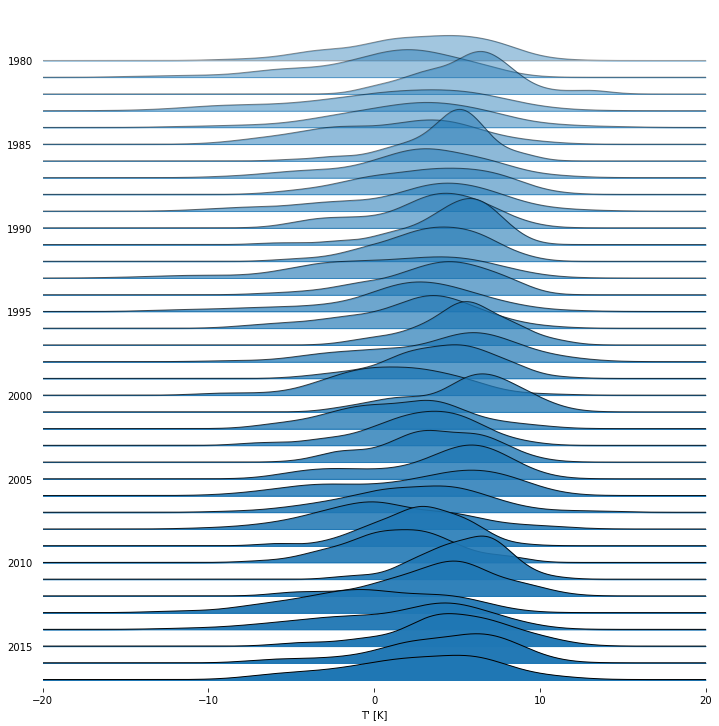

,year,t_prime
time,,
1980-12-01,1980,2.262002
1980-12-02,1980,3.391371
1980-12-03,1980,-2.898141
1980-12-04,1980,-2.111960
1980-12-05,1980,4.555823
...,...,...
2018-02-24,2017,3.644279
2018-02-25,2017,4.426621
2018-02-26,2017,3.188130


In [14]:
#choose a location
data_xr_chi = dm_tprime_xr.sel({'longitude': 272.5, 'latitude':42.0})
#now get rid of those extraeous location coords
data_xr_chi=data_xr_chi.reset_coords(['longitude', 'latitude'],drop=True)

#make it a dataframe for easier handling with joypy
data_df_chi = data_xr_chi.to_dataframe()
joy_div(data_df_chi)

## Overlayed KDEs

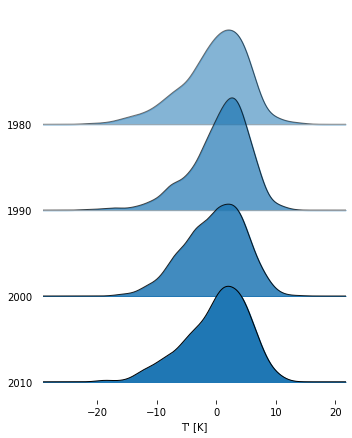

In [6]:
decadal_data = joy_div(data_df_chi,data_key='t_prime',decade=True)

In [7]:
def overlayed_decades(data,year,axis,clr='blue'):
    data_in_decade = data.loc[(data['decade']==year),'t_prime']
    sns.kdeplot(data_in_decade, ax=axis, shade=True, alpha=0.3, Label=str(year)+'s',color=clr)
    quantiles = np.quantile(data_in_decade,[0.1,0.9])
    plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
    plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)

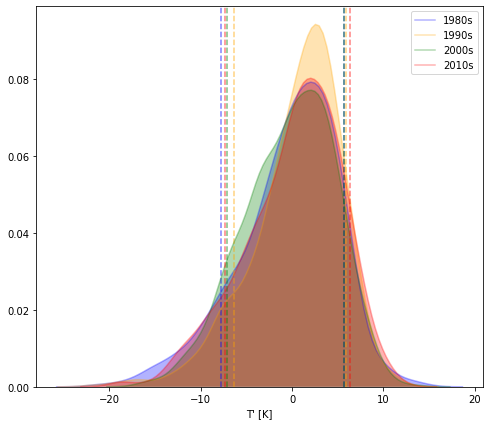

In [9]:
fig, ax = plt.subplots(figsize=(8, 7))
overlayed_decades(decadal_data,1980,ax,'blue')
overlayed_decades(decadal_data,1990,ax,'orange')
overlayed_decades(decadal_data,2000,ax,'green')
overlayed_decades(decadal_data,2010,ax,'red')
plt.xlabel("T' [K]")
plt.show()

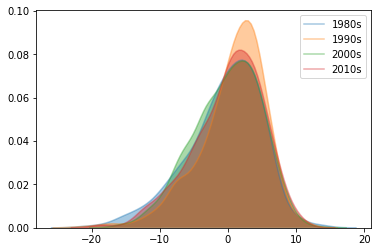

In [33]:
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==1980),'t_prime'], shade=True, alpha=0.4, Label='1980s')
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==1990),'t_prime'], shade=True, alpha=0.4, Label='1990s') 
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==2000),'t_prime'], shade=True, alpha=0.4, Label='2000s') 
sns.kdeplot(decadal_data.loc[(decadal_data['decade']==2010),'t_prime'], shade=True, alpha=0.4, Label='2010s') 